In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from DataHelper import *
import seaborn as sns
import matplotlib

plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


### Prepare data

In [3]:
DATA_PATH = './data'
QUOTATIONS = ['AMZN', 'GOOG', 'AAPL', 'GM', 'TSLA', 'JNJ', 'XOM', 'AAL', 'KO', 'WMT']
QUOTATIONS = ['IBM']
FILE_SUFFIX = '.txt'
price_column = 'Close'
project_label='LinearNN2Classes'

df = None
predict_n = 5

for quot in QUOTATIONS:
    #temp_df = pipeline_preprocessing(f"{DATA_PATH}/{quot}{FILE_SUFFIX}", predict_n=predict_n, price_column=price_column)
    temp_df, feature_names = features_pipeline(f"{DATA_PATH}/{quot}{FILE_SUFFIX}", predict_n=predict_n,
                                price_column=price_column, normalize_features=True, base_features_normalize=['Volume'])
    if df is None:
        df = temp_df
    else:
        df = df.append(temp_df)

print(len(df))
df.head()
df = df.dropna()

14760


In [4]:
df.isna().any()

Date                   False
Open                   False
High                   False
Low                    False
Close                  False
Adjusted               False
Volume                 False
Difference             False
PercentageDiff         False
Tendency               False
SMA(10)                False
SMA(20)                False
EMA(14)                False
EMA_Diff               False
SMA(20) - SMA(10)      False
LowLen                 False
RSI(14)                False
GAP                    False
RSI_Diff               False
Volume_diff            False
Next                   False
MACD                   False
MACD_diff              False
MACD_signal            False
BodyLen                False
BG_L_Band              False
BG_H_Band              False
BG_L_Band_Indicator    False
BG_H_Band_Indicator    False
ROC                    False
StochOsc               False
dtype: bool

In [5]:
from torch.utils.data import Dataset

class StocksDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.Tensor(data.values)
        self.target = torch.Tensor(target.values)
        
    def __getitem__(self, index):
        datapoint = self.data[index]
        target = self.target[index]
        return datapoint, target
        
    def __len__(self):
        return len(self.data)

y_column = 'Next'
data_columns = ['Close', 'Volume'] + feature_names
#data_columns = ['MACD', 'MACD_diff', 'RSI(14)', 'PercentageDiff', 'GAP'] + [y_column]


dataset = df.copy()
dataset = dataset.loc[:, data_columns]

for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':0})
    

    
X = dataset.loc[:, dataset.columns != y_column]
y = dataset[y_column]

X.head()

,Close,Volume,Difference,PercentageDiff,Tendency,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),...,MACD,MACD_diff,MACD_signal,BodyLen,BG_L_Band,BG_H_Band,BG_L_Band_Indicator,BG_H_Band_Indicator,ROC,StochOsc
33,7.346667,-0.970192,0.105809,0.070286,0,-0.980276,-0.979046,-0.980803,0.210844,-0.181677,...,0.238808,0.081335,0.217010,-0.963745,-0.979647,-0.977760,-1.0,-1.0,-0.365719,-0.375660
34,7.266667,-0.953776,0.095320,-0.070885,0,-0.981061,-0.979508,-0.981409,0.209483,-0.178637,...,0.236837,0.078876,0.215737,-0.979625,-0.980493,-0.977844,-1.0,-1.0,-0.411013,-0.542235
35,7.293333,-0.944920,0.091041,-0.124233,0,-0.981655,-0.979912,-0.981899,0.207081,-0.176848,...,0.235802,0.079002,0.214478,-0.995206,-0.981188,-0.977961,-1.0,-1.0,-0.397312,-0.498637
36,7.290000,-0.945352,0.085106,-0.200472,0,-0.982159,-0.980325,-0.982444,0.203304,-0.175984,...,0.234497,0.078498,0.213167,-0.983221,-0.981983,-0.978002,-1.0,-1.0,-0.409768,-0.651225
37,7.153333,-0.921376,0.095734,-0.064401,0,-0.982153,-0.980732,-0.982771,0.203066,-0.179829,...,0.234743,0.081565,0.212175,-0.979626,-0.982415,-0.978371,-1.0,-1.0,-0.294152,-0.455555


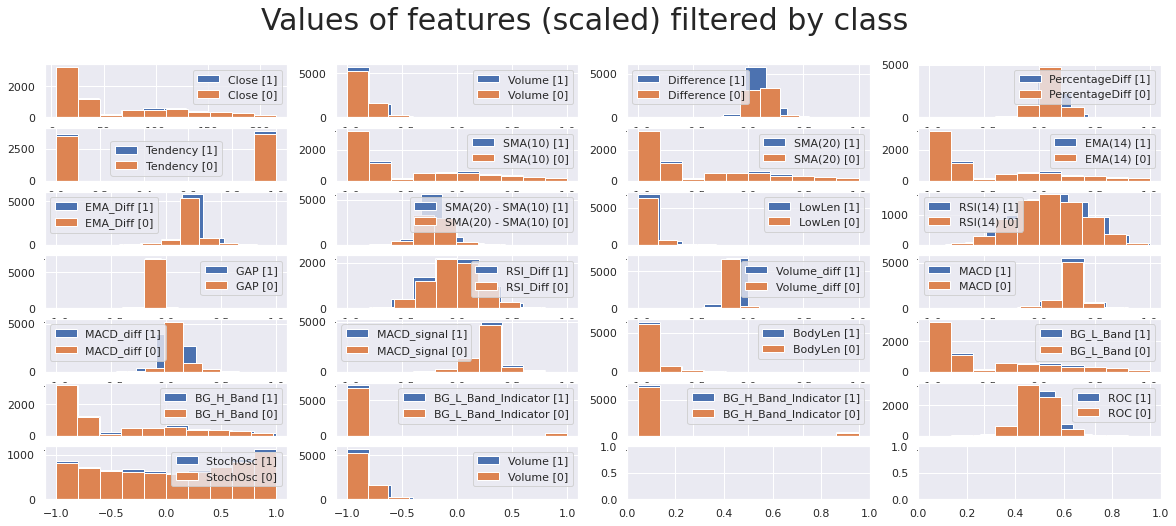

In [19]:
N_COLS = 4
plot_feature_names = data_columns.copy()

if 'Next' in plot_feature_names:
    plot_feature_names.remove('Next')
if 'Volume' in dataset.columns.values:
    plot_feature_names.append('Volume')
plot_filtered_class_features(dataset, n_cols=N_COLS, feature_names=plot_feature_names, class_column='Next')

plt.show()

In [20]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_dataset = StocksDataset(X_train,y_train)
test_dataset = StocksDataset(X_test, y_test)

print(f"Train size : {len(train_dataset)}, test_size : {len(test_dataset)}")

Train size : 10332, test_size : 4428


In [21]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

### Model

In [26]:
import torch.nn as nn

class LinearModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, **kwargs):
        super(LinearModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, output_dim),
            #nn.Softmax(1),
        )
        
        
    def forward(self, x):
        out = self.classifier(x)
        return out
    
import DL_utils
import importlib
importlib.reload(DL_utils)
from DL_utils import *

lr = 2e-5
model, optimizer, loss_fn = create_model(LinearModel, device=device, input_dim = len(X.columns), output_dim=1, 
                                            loss_fn=nn.BCEWithLogitsLoss, optimizer=torch.optim.Adam, lr=lr,
                                            use_wandb=True, project_label=project_label)

train(model, train_dataloader, n_epochs=5, optimizer=optimizer, loss_fn=loss_fn, device=device)

train_loss,0.69381
train_accuracy,49.17957
_runtime,7
_timestamp,1618306433
_step,4


train_loss,█▇▇▁█
train_accuracy,▁▁▂█▂
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 1, loss: 0.6931549906730652, accuracy : 50.85
Epoch 2, loss: 0.6962230801582336, accuracy : 50.89
Epoch 3, loss: 0.7004643082618713, accuracy : 50.95
Epoch 4, loss: 0.6983458995819092, accuracy : 50.90
Epoch 5, loss: 0.6940600872039795, accuracy : 51.07


In [27]:
import DL_utils
import importlib
importlib.reload(DL_utils)
from DL_utils import *

predictions, labels = predict(model, test_dataloader, device)

In [32]:
metrics_dict = compute_metrics(model, test_dataloader, device)

print(metrics_dict)

{'accuracy': 0.5313911472448057, 'roc_auc': 0.5108391682727571, 'f1_score': 0.6829640947288006}


Test accuracy : 53.14%


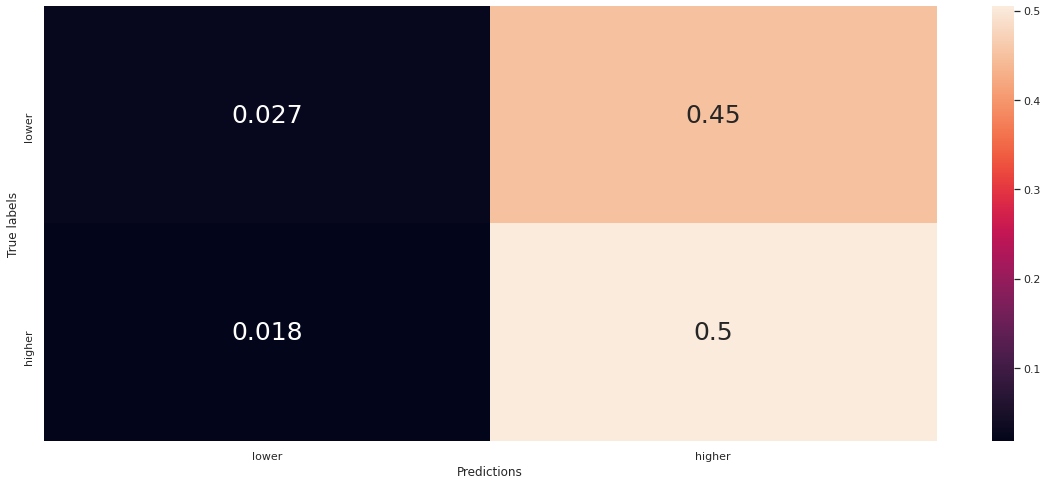

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(f"Test accuracy : {100 * metrics_dict['accuracy']:.2f}%")

class_labels = ['lower', 'higher']

ax = plot_heatmap(labels, predictions, class_labels, normalize='all')

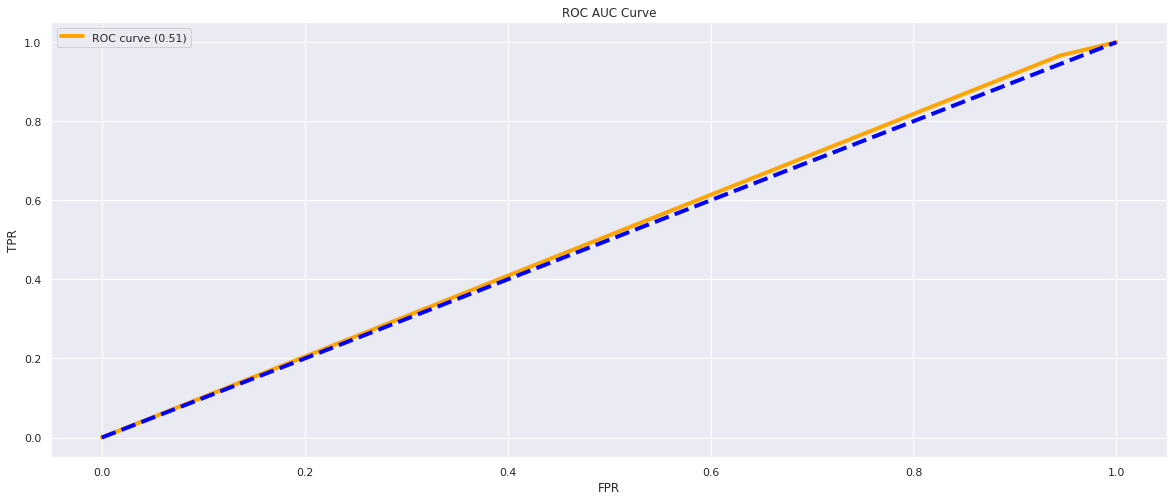

In [48]:
ax = plot_roc_auc_curve(labels, predictions)